[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Particle Filters

In [4]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2  
from __future__ import division, print_function
import matplotlib.pyplot as plt
import book_format
book_format.load_style()

** author's note: this is being written now. It is not ready to be read.**

Here is our problem. We have object moving in a space, and we want to track them. Maybe the objects are fighter jets and missiles in the sky, or maybe we are tracking people playing cricket in a field. It doesn't really matter. Which of the filters that we have learned can handle this problem? Well, none of them are ideal. Let's think about the characteristics of this problem. 

1. **multi-modal**: We want to track zero, one, or more than one object simultaneously.

2. **occlusions**: One object can hide another, causing there to be only one measurement for multiple objects.

3. **nonlinear behavior**: Aircraft are buffeted by winds, balls move in parabolas, and people collide into each other.

4. **nonlinear measurements**: Radar gives us the distance to an object. Converting that to an (x,y,z) coordinate requires a square root, which is nonlinear.

5. **non-Gaussian noise:** as objects move across a background the computer vision can mistake part of the background for the object. 

6. **continuous:** the object's position and velocity (i.e. the state space) can smoothly vary over time.

7. **multivariate**: we want to track several attributes, such as position, velocity, turn rates, etc.

None of the filters we have learned work well with all of these constraints. 

* **Discrete Bayes filter**: This has most of the attributes. It is multimodal, can handle nonlinear measurements, and can be made to work with nonlinear behavior (in this book we only handled the linear case). However, it is discrete, not continuous, and it is *univariate*, not multivariate.

* **Kalman filter**: The Kalman filter produces optimal estimates for unimodal linear systems with Gaussian noise. None of these are true for our problem.

* **Unscented Kalman filter**: The UKF handles nonlinear, continuous, multivariate problems. However, it is neither multimodal nor does it handle occlusions. It can handle noise that is modestly non-Gaussian, but does not do well with distributions that are very non-Gaussian or problems that are very nonlinear.

* **Extended Kalman filter**: The EKF has the same strengths and limitations as the UKF, except that is it even more sensitive to strong nonlinearities and non-Gaussian noise.

## Monte Carlo Sampling

In the UKF chapter I generated a plot similar to this to illustrate the effects of nonlinear systems on Gaussians:

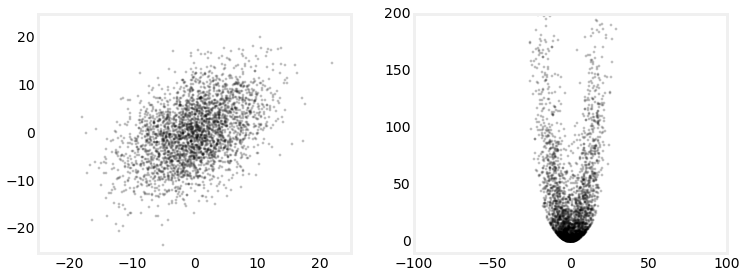

In [6]:
import pf_internal
pf_internal.plot_monte_carlo_ukf()

On the left I created 3000 points normally distributed based on the Gaussian

$$\mu = \begin{bmatrix}0\\0\end{bmatrix},\, \, \, \Sigma = \begin{bmatrix}32&15\\15&40\end{bmatrix}$$


and passed them through the system

$$\begin{aligned}x&=x+y\\
y &= 0.1x^2 + y^2\end{aligned}$$ 

I then showed how poorly the EKF did at estimating the new mean and covariance compared to the UKF.

This technique of using a finite number of randomly sampled to compute a result is called a **Monte Carlo** (MC) method. The idea is simple. Generate *enough* points to get a representative sample of the problem, run the points through the system you are modeling, and then compute the results on the transformed points. 


In a nutshell this is what particle filtering is. A bit later I'll demonstrate how MC can integrate over a probability distribution, but you don't need that formality to understand how they work. It's very simple. It is just the Bayesian filter algorithm we have been using throughout the book applied to thousands of particles, where each particle represents a *possible* state for the system.

1. **Randomly generate a bunch of particles**
    
  Particles can have position, heading, and/or whatever other state variable you need to estimate.
  Each has a weight indicating how likely it matches the actual state of the system.
  
2. **Predict next state of the particles**

  Advance the particles to the next time step based on a system model and noise model.
  
3. **Update**

  Update the weighting of the particles based on a measurement.
  
4. **Resample**
  Discard highly improbable particle and replace them with copies of more probable particles
  
  Optionally, compute mean and covariance of the set of particles to get the most likely current state.
  
  
  
  
This naive algorithm runs into some practical difficulties which we will need to overcome, but this is the general idea. To demonstrate this I wrote a particle filter that performs robot localization. This is the same robot localization problem used in the UKF and EKF chapter. In this problem we have a robot that we can control. It has sensors that measure its distance to various landmarks, and we can steer the robot. Both the sensors and control mechanism have noise in them, and we need to estimate the robot's position.

Here I run the particle filter and plotted the positions of the particles. The plot on the left is after one iteration, and on the right is after 10. The asterisk is the actual position of the robot, and the large circle is the computed weighted mean position.

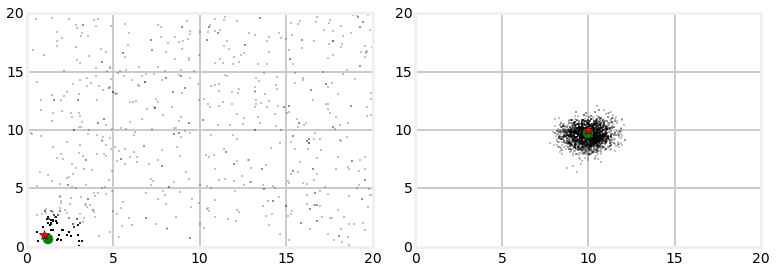

In [14]:
pf_internal.show_two_pf_plots()

After the first iteration the particles are still largely randomly scattered around the map, but you can see that some have already collected near the robot's position. The computed mean is quite close to the robot's position. This is because each particle is weighted based on how closely it matches the measurement. The measurement (with noise) says the robot is near (1,1), so particles that are near (1, 1) will have a high weight, and particles at, say, (15, 19.5) will have a very low weight. The estimated  is computed as the weighted mean of all of the particle's positions, so the estimate is quite accurate. This is partially the result of the random number generation - other runs could produce a poor estimate if no particles were particularly near the robot.

Several iterations later you can see that all the particles have clustered around the robot. This is due to the **resampling** step. Resampling discards particles that are very improbable (very low weight) and replaces them with particles with higher probability. There are multiple algorithms for this, and we will discuss them later. 

I haven't fully shown *why* this works nor fully explained the algorithms for weighting and resampling, but it should make intuitive sense. Make a bunch of random particles,  move them so they follow the robot, weight them according to how well they match the measurements, only let the likely ones live, and continue. It seems like it should work, and it does. 

Suppose we want to know the area under the curve $y= e^{1/x}$ in the interval [1,2]. We can compute the area by taking the definite integral. Go ahead and compute the answer; I'll wait. If you are wise you did not take that challenge; $y= e^{1/x}$ has no integral and so you can not find the answer this way.

However, this is trivial to compute using a Monte Carlo (MC) technique. Create a bounding box that contains the curve in the desired interval, generate random pairs $(x,y)$, and count how many fall under the curve. Multiply the area of the bounding box by the ratio of points that were under the curve vs the total number of points and you will have computed the are under the curve. As you tend towards infinite points you can achieve any arbitrary precision. In practice, a few thousand points will give you a fairly accurate result.

Think of how powerful this technique is. You can use it to numerically integrate any function. The function can be of any arbitrary difficulty, including being non integrable and noncontinuous, and yet we can trivially find the answer. 

Let's use it to compute $\pi$ by computing the area of a circle. This is very easy. We will create a circle with radius 1, and bound it in a square. The means that the length of a side of the box will be 2, and hence the area of the box is 4. We will generate a set of uniformly distributed random points within the box, and count how many fall inside the circle. The area of the circle is then the area of the box times the ratio of points inside the circle over the total number number of points. Finally, we know that $A = \pi r^2$, so $\pi = A / r^2$.

We start by creating the points.

    N = 20000
    ps = uniform(-1, 1, (N, 2))

A point is inside the circle if it's distance from the center point (0, 0) is less than or equal to one. We can compute the distance by using `numpy.linalg.norm`. If you aren't familiar with this, the norm is the magnitude of a vector. Since vectors start at (0, 0) calling norm will compute the point's distance from the origin.

    dist = np.linalg.norm(ps, axis=1)

Next we compute which of this distances fit the criteria with this code, which returns a bool array that contains `True` if it meets the condition

    in_circle = dist <= 1

All that is left is to count the points inside the circle, compute pi, and plot the results. I've put it all in one cell so you can experiment with alternative values for `N`.

mean pi(N=20000)= 3.1252
err  pi(N=20000)= 0.0164


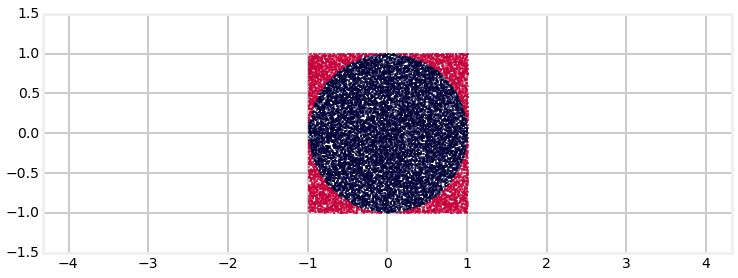

In [3]:
import numpy as np
from numpy.random import uniform 

N = 20000
ps = uniform(-1, 1, (N, 2))
dist = np.linalg.norm(ps, axis=1)
in_circle = dist <= 1

in_circle_count = np.count_nonzero(in_circle)
area = 2*2
pi = area*(in_circle_count / N)

plt.scatter(ps[in_circle,0], ps[in_circle,1], marker=',', edgecolor='k', s=1)
plt.scatter(ps[~in_circle,0], ps[~in_circle,1], marker=',', edgecolor='r', s=1)
plt.axis('equal')

print('mean pi(N={})= {:.4f}'.format(N, pi))
print('err  pi(N={})= {:.4f}'.format(N, np.pi-pi))

I show this to you to help illustrate that you really are computing a numerical integration. An alternative way to find the area of a circle is by integrating the infinitely many circles that lie inside the circle:

$$A = \int_0^{2\pi r} 2\pi t\, dt = \pi r^2 $$

The Monte Carlo technique does something very similar by summing the infinite number of points inside the circle. Computers can't sum infinities, so we settle for a representative sampling of points and less than infinite precision in the results.

This insight leads us to the realization that we can use Monte Carlo to compute the probability density of any probability distribution. For example, suppose we have a Gaussian. The Gaussian has a  probability distribution as shown below.

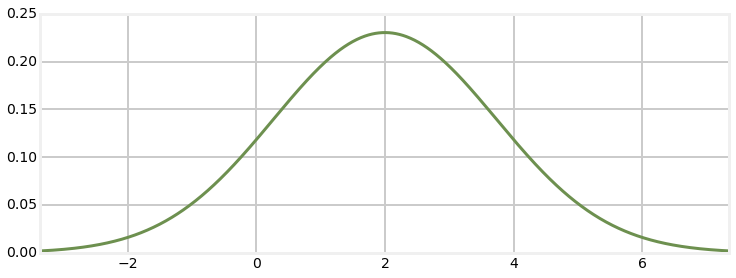

In [4]:
from stats import plot_gaussian
plot_gaussian(mean=2, variance=3)

The *probability density function* (PDF) is the probability that the random value falls between 2 values. For example, we may want to know the probability of x being between 0 and 2 in the graph above. This is a continuous function, so we need to take the integral to find the area under the curve, as the area is equal to the probability for that range of values to occur. 
 
$$P[a \le X \le b] = \int_a^b f_X(x) \, dx$$

It is easy to compute this integral for a Gaussian. But real life is not so easy. For example, the plot below shows a possible and realistic probability distribution. There is no way to analytically describe the curve, let alone integrate it symbolically.

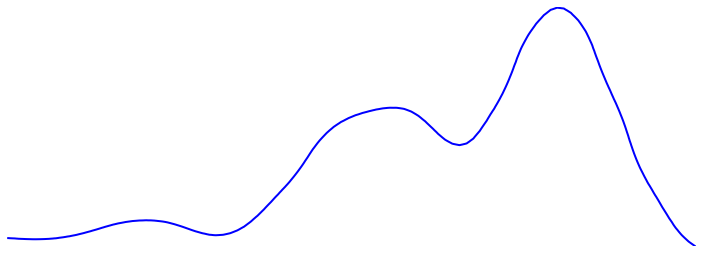

In [5]:
pf_internal.plot_random_pd()

But we have already stated that we can use Monte Carlo methods to compute any integral. The PDF is computed with an integral, hence we can compute the PDF of this curve using Monte Carlo. 

## The Particle Filter

All of this brings us to the particle filter. Consider tracking a robot or a car in an urban environment. For consistency I will use the robot localization problem from the ends of the EKF and UKF chapters. In this problem we tracked a robot that had a sensor that could detect the range and bearing to landmarks. 

This is a book on Bayesian filters, and I hope by now you expect us to use the standard Bayesian algorithm of update and predict cycles. We will. 

Taking insight from the discussion above we start by creating several thousand **particles**. Each particle has a position that represents a possible belief of where the robot is in the scene, and perhaps a heading and velocity. Suppose that when we initialize the filter we have no knowledge of the location of the robot. We would want to scatter the particles uniformly over the entire scene. If there was a large clump of particles near a specific location that would imply that we were more certain that the robot is there. If you think of all of the particles representing a probability distribution, locations where there are more particles represent a higher belief, and locations with fewer particles represents a lower belief.

Think back to the *Discrete Bayes* chapter. In that chapter we modeled positions in a hallway as discrete and uniformly spaced. This is very similar except the particles are randomly distributed.

Each particle needs a weight - a probability that it represents the true position of the robot. At initialization we have no reason to favor one particle over another, so we would typically assign a weight of $1/n$, where $n$ is the number of particles. We did the same thing in the discrete Bayes chapter. When we initialized the filter we assigned a probability of 1/N to each hallway position. The reason for $1/n$ is simple - the sum of all probabilities must equal one, and of course $\sum\limits_{i=1}^n \frac{1}{n} = 1$.

We will be operating on many particles so it is imperitive that we are as efficient in our programming as possible. That means storing the particles in an NumPy `array` and making full use of its vectorization capabilities.

To track our robot we need to maintain states for x, y, and heading. We will store `N` particles in a `(N, 3)` shaped array. The three columns contain x, y, and heading, in that order.

In this problem the robot can move on a plane of some arbitrary dimension, with the lower right corner at (0,0).
Here is a partial implementation of this problem. The particles are initially randomly distributed over the space, and are given a random heading. 

In [1]:
import numpy as np
from numpy.random import uniform

class ParticleFilter(object):

    def __init__(self, N, x_dim, y_dim):
        self.particles = np.zeros((N, 3))  # x, y, heading
        self.N = N
        self.x_dim = x_dim
        self.y_dim = y_dim

        # assign reasonable default.
        self.weights = np.array([1./N] * N)
        self.particles[:, 0] = uniform(0, x_range, size=N)
        self.particles[:, 1] = uniform(0, y_range, size=N)
        self.particles[:, 2] = uniform(0, 2*np.pi, size=N)

### Predict Step

The predict step in the Bayes algorithm predicts the movement of the robot and to update our belief in the robot's position by that movement. How would we do that with particles? Each particle represents a possible position for the robot. Suppose we send a command to the robot move 0.1 m at an angle of 1.3 radians. We would want to update each particle by moving it using the same command. If we did that exactly we would soon run into a problem - it is very unlikely that any given particle exactly represents the robot's position. So, we will add some noise to the particle movement proportional to the noise in the real robot's movement mechanism. If it is highly likely to overshoot and very unlikely to undershoot then we will do the same to the particles - make most overshoot, and a few undershoot. If you do not model the uncertainty in the system the particle filter will not correctly model the probability distribution of our belief in the robot's position. 

If this wasn't a robot, but something you are tracking passively, then you would want to include things like velocity in the particle state and use that estimate to make the prediction. When using particle filters I try to minimize the dimensionality of the problem; if I add 2 random variables I will probably have to increase the number of particles to ensure I have enough samples to correctly sample from the probability distribution of each. This can quickly become intractable. Thus I've excluded velocity from this problem.

I cannot easily modify a class definition in Jupyter Notebook, so I will show you the method in text. The entire class is in pf_internal, and we will be importing when we run the filter. 

    def predict(self, u, std):
        """ move according to control input u with noise std"""

        self.particles[:, 0:2] += u + randn(self.N, 2) * std

### Update Step

Next we get a set of measurements - one for each landmark currently in view. How should these measurements be used to alter our probability distribution as modeled by the particles?

Think back to the *Discrete Bayes* chapter. In that chapter we modeled positions in a hallway as discrete and uniformly spaced. We assigned a probability to each position. When a new measurement came in we multiplied the current probability of that position by the probability that the measurement matched that location. We implemented that like this:

    def update(map_, belief, z, prob_correct):
        scale = prob_correct / (1. - prob_correct)
        for i, val in enumerate(map_):
            if val == z:
                belief[i] *= scale
        normalize(belief)

We will want to do the same thing with our particles. Each particle has a position. We can also assign it a weight or probability based on how well it matches the measurement. We will want to multiply that new probability into the current weight of the particle. If we then normalize the weights of the particles those that are closest to the robot will generally have a higher weight than ones far from the robot.



And that is the general framework for the particle filter. The particles and their weights represent the probability distribution of our belief. This algorithm works well for multiple objects; clusters of particles will group around each object. We can compute the position of the robot by computing the mean of the point positions multiplied by their weights. This is more complicated if we have multiple  objects as we have to run some sort of clustering algorithm to determine which particles belong to which object, but that isn't hard. 

This is a complete implementation of a particle filter using the Bayesian framework that we have used throughout the book. If you were to implement it you would find that it rarely performs well. I'd rather get to a working example quickly, so I will skip implementing it and just tell you about the problems. If you do a historical survey of particle filters you will see that it took some time to discover and fix all of these issues. 

### Particle Resampling


The first problem we face is called the **degeneracy problem**. We initialize a large area with uniformly distributed particles. The number of particles near the robot are likely to be low. As we perform the algorithm above any particle modestly far from the robot will quickly acquire an extremely low weight, and only one or two particles near the robot with has an appreciable weight. The filter depends on many hundreds to thousands of particles to depict the probability distribution.  Only one or two near the robot will cause it to fail.

This problem is solved by some form of **resampling** of the particles. Suppose we notice that the number of particles that have relatively high weights is small. We want to 

## some title

The particle filter is easy to understand, and I could explain the entire algorithm to you now. But I want you to understand it within the context of the other Bayesian filters in this book. When you design a filter you first have to choose which filter to use, and understanding the relative strengths and weaknesses of each is important.

So let's start with a chart we first saw in the *Nonlinear Filtering* chapter. We started with a Gaussian with a mean of 0 and a variance of 1 and created 500,000 random points fitting that distribution. We passed each of those points through a nonlinear function, and plotted the result.

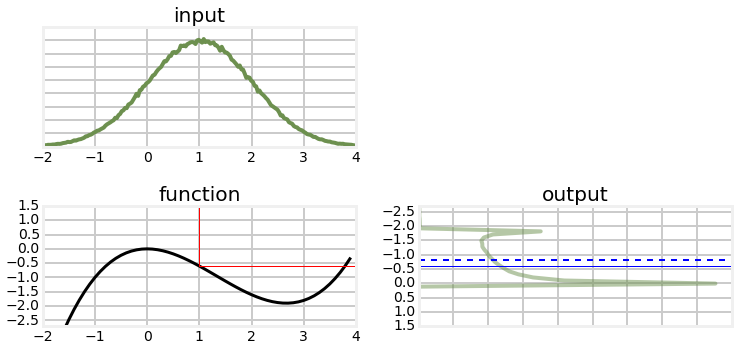

In [6]:
import numpy as np
from numpy.random import normal
from nonlinear_plots import plot_nonlinear_func

gaussian = (1., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def g(x):
    return .2*x**3 - .8*x**2

with book_format.figsize(y=5):
    plot_nonlinear_func(data, g, gaussian)

The EKF deals with this problem by linearizing the function at $x$ by evaluating the derivative at x: $f'(x)$. This computes the slope of the function at $x$, which is a linear function. If the function is smooth and 'fairly' linear locally the EKF produces a reasonable but suboptimal result. We can see from the chart above how much error is incurred with this linearization. 

The UKF handles larger nonlinearities by taking $2n+1$ samples near $x$. These samples are passed through the function, and the mean and standard deviation of the transformed points are used as the new estimate for the system state. In general this provides better estimates than the EKF at the cost of more computation. 

The EKF represents the nonlinearity of the function with one point, and the UKF represents it with $2n+1$ points. This allows them to handle the nonlinearity of the function, but in the end both assume a Gaussian distribution by taking the mean and standard deviation of the sampled points. 

It has probably occurred to you that the code that I used to graph the solution above constitutes an accurate solution, and it is. In other words, if we take a *large enough* sample from any probability distribution and pass them through our function the result will be an accurate representation of the new mean and probability distribution. 

## Monte Carlo Method


** old stuff - to be deleted/incorporated **

All of this brings us to the particle filter. Consider tracking a robot or a car in an urban environment. For consistency I will use the robot localization problem from the ends of the EKF and UKF chapters. In this problem we tracked a robot that had a sensor that could detect the range and bearing to landmarks. 

Taking insight from the discussion above we start by creating a several thousand **particles**. Each particle has a position that represents a possible belief of where the robot is in the scene. Suppose that when we initialize the filter we have no knowledge of the location of the robot. We would want to scatter the particles uniformly over the entire scene. If there was a large clump of particles near a specific location that would imply that we were more certain that the robot is there. If you think of all of the particles representing a probability distribution, locations where there are more particles represent a higher belief, and locations with fewer particles represents a lower belief.

Next we get a set of measurements - one for each landmark currently in view. How should these measurements be used to alter our probability distribution as modeled by the particles?

Think back to the *Discrete Bayes* chapter. In that chapter we modeled positions in a hallway as discrete and uniformly spaced. We assigned a probability to each position. When a new measurement came in we multiplied the current probability of that position by the probability that the measurement matched that location. We implemented that like this:

    def update(map_, belief, z, prob_correct):
        scale = prob_correct / (1. - prob_correct)
        for i, val in enumerate(map_):
            if val == z:
                belief[i] *= scale
        normalize(belief)

We will want to do the same thing with our particles. Each particle has a position. We can also assign it a weight or probability. We can compute the probability of the measurements matching that 

Here is a function that creates a particle in a square with a random velocity. We ignore units, trusting that the caller will use self consistant units such as MKS. Each particle is represented as a list with the structure `[x_position, y_position, speed, direction]`

In [7]:
from random import uniform
from math import pi
def make_particle(xrange=(0, 100), yrange=(0, 100), max_velocity=2.):
    return [uniform(*xrange), uniform(*yrange), 
            uniform(0, max_velocity), uniform(0, 2*pi)]

Here we create 1000 random plots and plot them.

In [8]:
particles = np.asarray([make_particle((0, 100), (0, 100), 2) for i in range(1000)])

Now we can write code that moves the particle over a period of time.

In [9]:
def move(particles, t=1.):
    vx = particles[:, 2]*np.cos(particles[:, 3])
    vy = particles[:, 2]*np.sin(particles[:, 3])
    particles[:, 0] = (particles[:, 0] + vx*t) % 100
    particles[:, 1] = (particles[:, 1] + vy*t) % 100

So let's plot the particles, move them, and plot them again

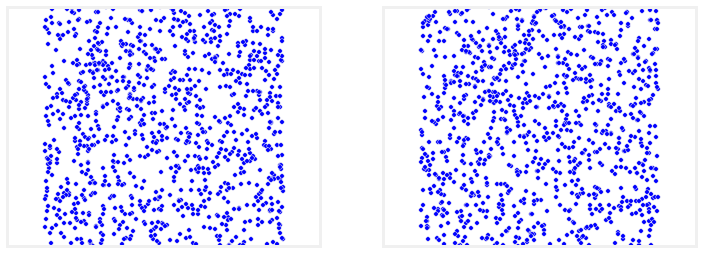

In [10]:
def plot_particles(particles, x_range=(0, 100), y_range=(0, 100)):
    with book_format.figsize(4,4):
        plt.scatter(particles[:, 0], particles[:, 1])
        plt.axis('equal')
        plt.xlim(*x_range)
        plt.ylim(*y_range)
        plt.gca().get_xaxis().set_ticks([])
        plt.gca().get_yaxis().set_ticks([])

plt.subplot(121)
plot_particles(particles)
move(particles, t=10)
plt.subplot(122)
plot_particles(particles)

So we have a random distribution of particles, how do we use them to track objects? Think of these particles as *beliefs*. We want each particle to represent a possible belief for the movement of a tracked object. Each particle only contains a position and velocity, so we need a separate data structure to contain the probability that the particle is tracking an object. Much like we did in the **Discrete Bayes** chapter we can use a NumPy array to store the probabilities. 

We have not yet incorported any measurements, so if you recall from the Bayesian math sections we would call this our *prior*, as it contains the probability *prior* to adding a measurement. With no measurements we have no reason to believe any particular particle is more likely to be correct than any other particle, so it is reasonable to assign the same probability to each. We want a *probability distribution*, which means that the sum of the probabilities of all the particles must be one. Here is some code to do that.

In [11]:
N=len(particles)
p = np.array([1/N]*N)

We have 1,000 particles so the probability for each particle is 0.001 (1/1000). 

Now how do we incorporate measurements? Say we run our computer vision software on the first video frame and it reports that there is a blob at (43.2, 21.8). We can evaluate how likely each particle is taking that measurement into account. I don't want to get bogged down in the math at the moment, but recall that we would write that as $P(particle|blob)$. I bring that up to emphasize that this is a *Bayesian* filter- we incorporate new information to adjust our current beliefs. 

We don't yet know how to compute the new probabilities for the particles, but we can reason that a particle at (0,0), far from the measurement, would have a very low probability of representing the object, whereas a particle at (42.9, 21.9) should have a relatively high probability of representing the object.

In [12]:
from sympy import *
from sympy.abc import x


a = cos(4*(x/2 + 0.7)) * sin(0.3*x) - 1.6*x
da = diff(a,x)
da.subs(x, 0)

-1.88266670220060

objects in a two or three dimension space. via computer vision, radar, or other sensing technique. There might be zero, one, or multiple objects in view at once. We may or may not be able to mathematically describe the behavior of the tracked objects. If we are tracking passenger jets with radar we can model the behavior because large aircraft do not change direction or speed rapidly. If we are tracking people in a crowd, a ball on a football field, or fighter jets our prediction model will range from difficult to impossible. Finally, our measurements are likely to have very strong outliers. A bird flying in front of a camera tracking a sporting event is quite likely to fool the computer vision by creating spurious detections - the bird will be misidentified as a player or the ball. In radar design the designer has to account for noise - either domestic noise or hostile jamming in the case of war environments.

So our problem is multi-modal, has a non-Gaussian to nonexistent process model, and has non-Gaussian measurements. Finally, both the measurements and behavior of the tracked objects are likely to be nonlinear.

None of the filters that we have learned so far are particularly good at solving this problem. 
The Kalman filter provides optimal output if and only if the data and object behavior is Gaussian and linear. The extended Kalman filter (EKF) and unscented Kalman filter (UKF)  

The discrete Bayes filter is multimodal and can handle nonlinear 

The filters that we have encountered so far is this book are very powerful, but they have significant limitations and difficulties. The discrete Bayes filter can track multiple objects at once because it is multi-modal, but it does not model the behavior of the tracked objects and it requires vast amounts of compute power and memory to represent large problems. The linear Kalman filter assumes that both the model and the measurements are Gaussian, and that both are linear. Of course, the world is not linear and data is rarely truly Gaussian. If these things are true then the Kalman filter produces an optimal solution, but in practice this is rare. Nonlinear Kalman filters, such as the unscented Kalman filter and extended Kalman filter deal with the nonlinearities in the process model and measurements by linearizing the problem. This allows the Kalman filter to work in nonlinear domains, but the linearization introduces inaccuracies that, in the worst case, causes the filter to diverge. There are filters which we haven't described in this book that are designed to handle data which is not fully Gaussian, but they again involve compromises.

Particle filtering is a technique that largely transcends these problems. As we will see it is still non-optimal, but 

## How the Particle Filter Works

Assume that we are trying to track objects in a two dimensional space. The particle filter starts by creating a random set of *particles*. Each particle is assigned a random location and velocity. Each particle represents one possible 